In [12]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/drive/MyDrive/research/vision_transformer")
    CHECKPOINT_DIR = DATA_ROOT/"vit_cifar_checkpoints"
    EXPERIMENT_DIR = DATA_ROOT/"experiments"
except:
    DATA_ROOT = Path.home()/"Desktop/research"
    CHECKPOINT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints"
    EXPERIMENT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/experiments"

if not DATA_ROOT.exists():
    DATA_ROOT.parent.mkdir(parents=True, exist_ok=True)
    print("Created Data dir")
else:
    print("DATA_ROOT exists at : ", DATA_ROOT)
    
if not CHECKPOINT_DIR.exists():
    CHECKPOINT_DIR.parent.mkdir(parents=True, exist_ok=True)
    # CHECKPOINT_DIR.mkdir()/
    print("created CKPT dir")
else:
    print("ckpt exists at : ", CHECKPOINT_DIR)


DATA_ROOT exists at :  /home/avishkar/Desktop/research
ckpt exists at :  /home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints


In [13]:
"""DATASET"""
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


torch.manual_seed(42)

DATASET = "cifar10"
NUM_WORKERS = 2
BATCH_SIZE = 32 

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    ]
)


train_dataset = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform= transform)
test_dataset = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform= transform)
print(f"trainset : {len(train_dataset)}, testset : {len(test_dataset)}")
classes = train_dataset.classes

# trainset = torch.utils.data.Subset(train_dataset, list(range(5000)))
# testset = torch.utils.data.Subset(test_dataset, list(range(1000)))

# prepare
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



Files already downloaded and verified
Files already downloaded and verified
trainset : 50000, testset : 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9875..0.8094669].


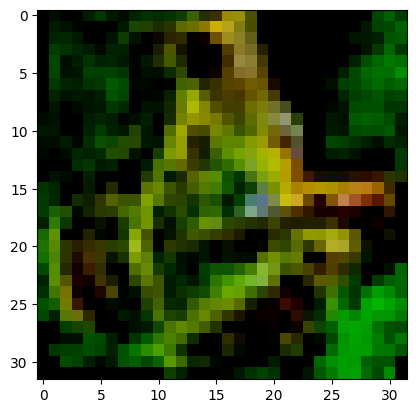

In [14]:
"""VISUALIZE DATA"""
import matplotlib.pyplot as plt

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    plt.imshow(img.T.cpu().numpy())
    plt.show()
    break
    


In [15]:
"""UTILS"""
import json
from pathlib import Path

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "accuracies":accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    
    

In [18]:
import torch.optim as optim
import torch

class Trainer:
    def __init__(self, model, optimizer, criterion, device, path=CHECKPOINT_DIR):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.path=path
        self.exp_dir = EXPERIMENT_DIR

    def train(self, train_loader, test_loader, num_epochs, save_model_every_n_epochs=0):
        train_losses = []
        test_losses = []
        accuracies = [] 

        for i in range(num_epochs):
            train_loss = self.train_epoch(train_loader)
            accuracy, test_loss = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != num_epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.model.state_dict(), i+1, train_losses, test_losses, accuracies, self.path)

        save_experiment(self.model, num_epochs, config, train_losses, test_losses, accuracies, self.exp_dir)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()* len(imgs)

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (imgs, labels) in enumerate(test_loader):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(imgs)
                
                loss = self.criterion(predictions, labels)
                total_loss += loss.item() * len(imgs)

                 # Calculate the accuracy
                predictions = torch.argmax(predictions, dim=1)
                correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        return accuracy, avg_loss

config = {
    "img_size":32,
	"patch_size":6,
	"num_channels":3,
	"num_layers":7,
	"num_heads":8,
	"embed_dim":768,
	"mlp_hidden_dim":4*768,
	"dropout":0.0,
	"num_classes":10,
    "lr":0.01,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "num_epochs":100,
    "exp_name":"vit_cifar10_mark2_100_epochs",
    "save_model_every":0
}

def main():
    save_model_every_n_epochs = config["save_model_every"]
    model = torchvision.models.vision_transformer.VisionTransformer(
    image_size=32,
    patch_size=4,
    num_layers=8,
    num_heads=4,
    hidden_dim=768,
    mlp_dim=4*768
) 
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
    criterion = torch.nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, criterion, device=config["device"])
    trainer.train(train_loader, test_loader, config["num_epochs"], save_model_every_n_epochs=save_model_every_n_epochs)

In [19]:
"""TRAINING"""
if __name__ == "__main__":
    main()

KeyboardInterrupt: 